### Implementation of Adaptive Viewing Selection for Optimized UAV Trajectory Planning

In [2]:
import trimesh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from skspatial.objects import Points, Plane
from skspatial.plotting import plot_3d
import sys
import pyrender 
from scipy.cluster.vq import kmeans2
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from math import atan2, cos, sin, pi, sqrt, degrees
from collections import namedtuple
import itertools
from shapely.geometry import LineString, MultiPolygon, MultiLineString, Polygon
from shapely.ops import split
import networkx as nx

### Load the Input Model (Mesh)

In [3]:
# Input object
mesh = trimesh.load('C:/Users/DR-PHELZ/Desktop/PTDF Scholarship/Weimar/Third Semester/Special Project/Models/Scherkonde_Section_clean.ply')

In [4]:
mesh.show()

#### Obtain the reduced center_points of the triangular mesh for the object

In [5]:
def center_points(mesh, radius_threshold):
    """
    mesh = Input mesh
    radius_threshold = desired radius
    ...this maintain a minimum distance (as defined) between trianular meshes"""
    centers = mesh.triangles_center
    reduced_points = trimesh.points.remove_close(centers, radius_threshold) 
    return pd.DataFrame(reduced_points[0], columns= ['x','y','z'])

In [6]:
data = center_points(mesh, 0.1)

In [7]:
def transform_data (data):
    """
    transforming the data so as to fit-in to regular scale based on
    min. to max. in preparation for Elbow method/ analysis"""
    scaler = MinMaxScaler()   
    scaler.fit(data)
    transformed_data = scaler.transform(data)
    return pd.DataFrame(transformed_data, columns = ['x','y','z'])

In [8]:
transformed_data = transform_data(data)

#### Estimate the optimum number of clusters (k), for the K-means clustering. Perform elbow analysis

In [9]:
def elbow(transformed_data, max_cluster):
    """
    max_cluster = maximum numbers of times (clusters) to run the analysis. This is dependent on input data and user experience
    
    The function estimates the optimal value for the number of clusters.
    Returns array of sum_squared_distance, as well as the image view of the elbow"""

    sum_squared_dist = []
    num_of_clusters = range(1,max_cluster)
    for _ in num_of_clusters:
        k_means = KMeans(n_clusters= _)
        k_means = k_means.fit(transformed_data)
        sum_squared_dist.append(k_means.inertia_)
    
    %matplotlib notebook
    plt.plot(list(num_of_clusters), sum_squared_dist, 'bx-')
    plt.xlabel('num_of_clusters')
    plt.ylabel('sum_squared_dist')
    plt.title('Optimal num_of_cluster')
    return sum_squared_dist

<IPython.core.display.Javascript object>


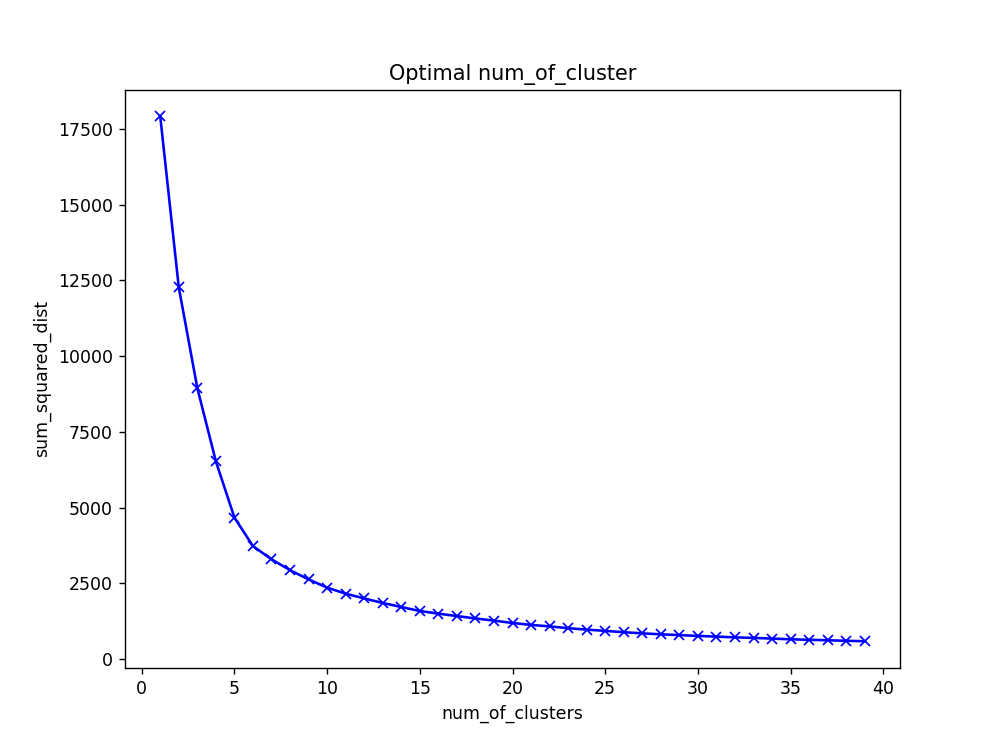

In [10]:
sum_squared_dist = elbow(transformed_data, 40)

In [11]:
# Select optimal number of clusters (using 90th percentile)
def optimal_num_of_cluster(sum_squared_dist):
    """
    sum_squared_dist = array of sum of squared distanced obtained from the elbow anylysis of transformed data
    Retruns the point where the deviation is less than 90th percentile of the Sum_sqaured_dist
    """
    sum_squared_dist = np.array(sum_squared_dist)
    diff_scores = sum_squared_dist / sum_squared_dist[0]
    diff_scores1 = np.diff(sum_squared_dist)
    num_of_clusters = np.argwhere(diff_scores1 < np.quantile(diff_scores, 0.9))[-1][0] 
    return num_of_clusters

In [12]:
numberOfClusters = optimal_num_of_cluster(sum_squared_dist)
numberOfClusters

37

In [13]:
def move_face(d, mesh =None,  pts_arr=None, normal_arr=None):   
    """points can be moved either by providing the "mesh to be used, or by providing both 
    (points array)"pts_arr" and corresponding (normal array)"normal_arr". 
    NOTE: pts_arr and normal_arr needs to be of thesame dimension
    
    # d = desired distance of movenment (usually d_obj)"""
    
    new_clusters = []
    # If mesh is provided, get the trisngle centers of each triangles and their corresponding normal 
    # vectors, then move the points to distance 'd' in the normal direction
    if mesh:
        face_pts = mesh.triangles_center
        face_normal = mesh.face_normals
        for _ in range (len(face_pts)):
            point = face_pts[_]
            normal = face_normal[_]
            normal = np.array(d* normal)
            new_position_plane = np.add(point, normal)
            new_clusters.append(new_position_plane)
    # If mesh is not provided, an array of points needs to be provided as well as their
    # corresponding normal array
    else:
        for _ in range (len(pts_arr)):
            point = pts_arr[_]
            normal = normal_arr[_]
            normal = np.array(d* normal)
            new_position_plane = np.add(point, normal)
            new_clusters.append(new_position_plane)
    new_clusters = np.array(new_clusters)
    return new_clusters

#### The points on the surface of the mesh were moved in the direction of Normal (N on each associated triangular mesh). These moved points were then clustered based on k-means that obtain the k-numbers of centroids and clustered all other points to the corresponding centroids.

#### After the initial clustering, there exist second phase of clustering (further_division)based on the normal (N) direction 

In [14]:
def cluster_moved_pts(mesh, numberOfClusters, d_obj, further_division = None):
    """
    mesh = input mesh
    numberOfClusters: specify the integer value for k to me used (k-means clustering)
    d_obj: distance to the object (desired distance to move the surface points)
    further_division: indicate the number (int) of sub-division for each clusters  
    
    ... when complete_clustering =True, it further clusters initial surface
    If further_division = None, It is set to int(3)
    # each_division indicate the number of clusters (int) for each clusters initially specified
    # Returns points on mesh, separate clusters(of moved points), with corresponding normal vectors""" 
    
    sol = [np.array([]) for _ in range (numberOfClusters)]
    sol_norm_vectors = [np.array([]) for _ in range (numberOfClusters)]
    if further_division == None:
        further_division = 3
    moved_pts = [np.array([]) for _ in range (int(numberOfClusters*further_division))]
    sol_normal_vectors = [np.array([]) for _ in range (int(numberOfClusters*further_division))]
    points = [np.array([]) for _ in range (int(numberOfClusters*further_division))]
    
    face_pts = mesh.triangles_center   # Obatin center-points of mesh
    face_normal = mesh.face_normals    # and corresponding normal vector
    centroid, idx = trimesh.points.k_means(face_pts, numberOfClusters)
    for i in range (numberOfClusters):
        sol[i] = face_pts[idx == i]
        sol_norm_vectors[i] = face_normal[idx ==i]
    
    # small_clustering would be done based on normal (N)
    cnt = 0
    for i in range (len(sol)):
        a = face_pts[idx==i]
        b = face_normal[idx==i]
        further_centroid, further_idx = trimesh.points.k_means(b, further_division)
        unique_idx = np.unique(further_idx)
        for value in unique_idx:
            
            val= a[further_idx == value]
            points[cnt] = val
            sol_normal_vectors[cnt] = b[further_idx == value]
            moved_pts[cnt] = move_face(d=d_obj, mesh =None,  pts_arr=val, normal_arr= sol_normal_vectors[cnt])
            cnt += 1
    return points, moved_pts, sol_normal_vectors

### For Water-tight structures/Models
#### Identify whether moved clusters (all or parts) are in Hull. This test may be needed only when dealing with water-tight models and it is expected that the path adequately covers the entire outside sections of the model

In [15]:
def in_hull(points, hull):
    """
    For a 3d points, 'points' should be a 'N by 3' or 'N by K' for k-dimesnsions. coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)
    # returns True if specific point is in hull, and False otherwise 
    return hull.find_simplex(points)>=0  

In [16]:
def is_cluster_inHull(mesh, cluster_points):
    """
    Function only useful for a watertight structure/object.
    If you already have the coordinates of 3d points that forms the hull, use 
    in_hull(points, hull) function instead
    
    The fuction returns True/Flase as well as the numbers of points in Hull
    """
    mesh_hull_vertices = mesh.convex_hull.vertices
    # Test if cluster points are inside mesh
    is_in_mesh = np.array(in_hull(points = cluster_points, hull = mesh_hull_vertices))    
    # From each cluster (e.g cluster C_1), count the numbers of points inside the hull. This is because 
    # there are times when only a section/part of the cluster whould be inside the Hull
    # The idea is to later chenck If more than 50% of the clusters are inside the hull, move the cluster in the opposite direction 
    count = np.count_nonzero(is_in_mesh)
    total_cluster_pts = len(cluster_points)
    
    if count > int(total_cluster_pts*0.5):
        return True, count
    else:
        return False, count  # count = the number of points in Hull

In [17]:
def delete_Empty(array): # this function removes empty array from lists of multilayered 2d arrays 
    cnt = 0
    for i in range (len(array)):
        if np.size(array[cnt], axis =0) ==0:
            array.pop(cnt)
        else:
            cnt += 1
    return array

### PLOT FUNCTIONS

In [18]:
def plot_multiple(mesh, cluster_points):
    """
    cluster_points :- (n_x_3) by k array of clusters, where k is the number of clusters,
    this function would display all the clusters, and show each cluster with a distinct (random) colour 
    """
    scene = mesh
    for x in range(0, len(cluster_points)):
        cloud_color = np.array([trimesh.visual.random_color()])
        cloud_original = trimesh.points.PointCloud(cluster_points[x], colors= cloud_color[0], metadata=None)
        scene = trimesh.Scene([scene, cloud_original])
    scene = trimesh.viewer.SceneViewer(scene, smooth=True, flags=None, visible=True, resolution=None,
                                start_loop=True, callback=None, callback_period=None, 
                                caption=None, fixed=None, offset_lines=True, line_settings=None, 
                                background=None, window_conf=None, profile=False)
    return scene


def plot_single_cluster (mesh, cluster_points):
    """
    cluster_points :- nx3 array of of points (a single cluster)
    """
    cloud_color = np.array([trimesh.visual.random_color()])
    cloud_original = trimesh.points.PointCloud(cluster_points, colors=cloud_color[0], metadata=None)
    scene = trimesh.Scene([mesh, cloud_original])
    return trimesh.viewer.SceneViewer(scene, smooth=True, flags=None, visible=True, resolution=None, 
                                      start_loop=True, callback=None, callback_period=None, caption=None, 
                                      fixed=None, offset_lines=True, line_settings=None, background=None, 
                                      window_conf=None, profile=False)


def plot_cluster_points(mesh, clusters):
    """
    This function is similar to plot_single_cluster function, but Plot without the use of 
    trimesh scene-viewer
    """
    cloud_color = np.array([trimesh.visual.random_color()])
    cloud_original = trimesh.points.PointCloud(clusters, colors= cloud_color[0], metadata=None)
    scene = trimesh.Scene([mesh, cloud_original])
    return scene.show()

### Separate Each Clusters to An Appropriate Array (to allow for further Analysis)
#### This is because a plane need to be fitted to each cluster.

In [19]:
def diff_cluster_axis (all_clusters, norm_arr, d_obj, mesh, is_moved = False):
    """If the supplied data(all_clusters) has already been moved, then set "is_moved = True", or False otherwise
    Return the cluster point in space with corresponding points on the object (if is_moved)
    However, in order to obtain the corresponding axis that a particular plane is more fitted into,
    for each cluster, there standard deviations are estimated for the x,y,z axis. The one with the smallest 
    outcome shows that there's very little variance in that particular axis, hence the cluster is lying more 
    to the particular axis .
    This was then done for all the clusters, and placed in the appropriate axis"""
    
    # Set up the array for each/expected solution set 
    x_up = [np.array([]) for _ in range(len(all_clusters))]
    y_up = [np.array([]) for _ in range(len(all_clusters))]
    x_down = [np.array([]) for _ in range(len(all_clusters))]
    y_down = [np.array([]) for _ in range(len(all_clusters))]
    z_up = [np.array([]) for _ in range(len(all_clusters))]
    z_down = [np.array([]) for _ in range(len(all_clusters))]
    
    for i in range (len(all_clusters)):
        move_clustr = move_face(d_obj, mesh =None,  pts_arr=all_clusters[i], normal_arr=norm_arr[i])
        fitted_plane = np.array(trimesh.points.plane_fit(all_clusters[i])[0])
        new_fitted_plane = np.array(trimesh.points.plane_fit(move_clustr)[0])  # fit plane to each clusters on the object
        #new_fitted_plane = fit_plane_for_clusters(move_clustrs)[0]   # fit new plane to the clusters at new position
        x_var = np.std(all_clusters[i][:,0])   # standtard deviation for x_axis values
        y_var = np.std(all_clusters[i][:,1])   # standtard deviation for y_axis values
        z_var = np.std(all_clusters[i][:,2])   # standtard deviation for z_axis values
        if (x_var <= y_var) and (x_var <= z_var) :
            
            #To determine whether a point is moving in positive (up) or negative (down) direction,
            # the fitted plane is moved to a new position (new_fitted_plane) wijth distance d. Then, if
            # the value of the axis of movement(e.g x_axis) of old points are greater than that of new points,
            # then, the plane has moved in the negative direction (or downward). OR vice-versa if the condition 
            #is directly opposite of that.
            if fitted_plane[0] > new_fitted_plane[0]:
                if is_moved:
                    x_down[i] = all_clusters[i], move_face(-1*d_obj, mesh =None,  pts_arr=all_clusters[i], normal_arr=norm_arr[i])
                else:
                    x_down[i] = all_clusters[i]
            else:
                if is_moved:
                    x_up[i] = all_clusters[i], move_face(-1*d_obj, mesh =None,  pts_arr=all_clusters[i], normal_arr=norm_arr[i])
                else:
                    x_up[i] = all_clusters[i]
        elif (y_var <= x_var) and (y_var <= z_var):
            if fitted_plane[1] > new_fitted_plane[1]:
                if is_moved:
                    y_down[i] = all_clusters[i], move_face(-1*d_obj, mesh =None,  pts_arr=all_clusters[i], normal_arr=norm_arr[i])
                else:
                    y_down[i] = all_clusters[i]
            else:
                if is_moved:
                    y_up[i] = all_clusters[i], move_face(-1*d_obj, mesh =None,  pts_arr=all_clusters[i], normal_arr=norm_arr[i])
                else:
                    y_up[i] = all_clusters[i]
        else:
            if fitted_plane[2] > new_fitted_plane[2]:
                if is_moved:
                    z_down[i] = all_clusters[i], move_face(-1*d_obj, mesh =None,  pts_arr=all_clusters[i], normal_arr=norm_arr[i])
                else:
                    z_down[i] = all_clusters[i]
            else:
                if is_moved:
                    z_up[i] = all_clusters[i], move_face(-1*d_obj, mesh =None,  pts_arr=all_clusters[i], normal_arr=norm_arr[i])
                else:
                    z_up[i] = all_clusters[i]
    # If any, delete all empty array, since len(all_clusters) is the maximum numbers of clusters that any 
    # sub-section can have 
    x_up = delete_Empty(x_up)
    y_up = delete_Empty(y_up)
    x_down = delete_Empty(x_down)
    y_down = delete_Empty(y_down)
    z_up = delete_Empty(z_up)
    z_down = delete_Empty(z_down)   # NOTE : z-down may NOT neccessarily occur for watertight object 
    
    return x_up, x_down, y_up, y_down, z_up, z_down

In [20]:
######################################################################################################

#### Used Case: 
##### To obtain x_up,  x_down,  y_up,  y_down,  z_up,  z_down

In [21]:
points, moved_pts, normal_vectors = cluster_moved_pts(mesh, numberOfClusters, 4, further_division = None)

In [22]:
x_up, x_down, y_up, y_down, z_up, z_down = diff_cluster_axis (moved_pts, normal_vectors, 4, mesh, is_moved=True)

In [23]:
## fit a plane for the cluster and return a point on the plane with the normal

def fit_plane_for_clusters(points):
    """
    points :- Array of 3d points to be used for fitting the plane  
    
    return a point on the fitted plane with the normal vector
    """
    point_on_fitted_plane = [[] for _ in range(len(points))]
    plane_normal = [[] for _ in range(len(points))]
    for x in range (0, len(points)):
        new_plane = trimesh.points.plane_fit(points[x])
        point_on_fitted_plane[x] = new_plane[0]   # <---- Point on the plane
        plane_normal[x] = new_plane[1]    # # <---- Normal
    point_on_fitted_plane = np.array(point_on_fitted_plane)
    plane_normal = np.array(plane_normal)
    return point_on_fitted_plane, plane_normal

##### Transfer points to the fitted plane (based on the axis that the plane is most fitted to)

In [24]:
# transfer points to plane (return 2d points)
def point_to_plane(points, axis):   # z_axis
    
    points_2d = [[] for _ in range(len(points))]
    if axis == 'z':
        for x in range (0, len(points)):
            points_on_plane = trimesh.points.project_to_plane(points=points[x], 
                                                      plane_normal=[0,0,1], plane_origin=[0,0,0], 
                                                      transform=None, return_transform=False, return_planar=True)
            points_2d[x] = points_on_plane
    

    # Point to plane (y-axis to the output)
    elif axis == 'y':
        #def point_to_plane_y_axis(points_3d):  
        #new_points_3d = [[] for _ in range(len(points_3d))]
        for y in range (0, len(points)):
            # select the adapted third axis point for the cluster
            points_2d[y] = np.delete(points[y], 1, axis=1)
            #new_points_3d[y] = points_2d
        #return new_points_3d

    elif axis == 'x':
    # Point to plane (x-axis to the output)
    #def point_to_plane_x_axis(points_3d):
        #new_points_3d = [[] for _ in range(len(points_3d))]
        for x in range (0, len(points)):
            points_2d[x] = np.delete(points[x], 0, axis=1)
            #new_points_3d[x] = points_2d
        #return new_points_3d
    
    else:
        print("Please provide valid axis.... 'x', 'y', or 'z'")
    
    return points_2d   

In [25]:
# This function can be used to move the group of 3d points in the direction of normal (N) to any fitted plane
# for the 30 points 
def move_points(cluster_points, d): # move 3d points
    """
    d: - distance of movement
    cluster_points :- array of clusters / 3d points
    
    Returns new Array of points (new position of the input "cluster_points")
    """
    new_clusters = [[] for _ in range(len(cluster_points))]

    for x in range (0, len(cluster_points)):   
        if np.size(np.array(cluster_points[x]), axis =0) < 1: # If the imput is an empty array/contain just one point
            new_clusters[x] = []
        else:
            points=  cluster_points[x]
            plane=trimesh.points.plane_fit(points)
            p=np.array(plane)
            first_half, second_half = p[:1] , p[1:]   # p[:1] <---- Point on the plane, and p[1:]<---- Normal
            # normalizing the normal vectors
            X_normalized = preprocessing.normalize(second_half, norm='l2')
            # here multiplying the first half with the desired distance we want
            normal = np.array(d* X_normalized)
            for _ in range(0, len(cluster_points[x])):
                #new_position_plane = np.add(points_reference,normal)  <---- #new_position = points_reference+ normal  
                new_position_plane = np.add(cluster_points[x][_], normal)
                new_clusters[x].append(new_position_plane)
            new_clusters[x] = np.array(new_clusters[x])
            new_clusters[x] = new_clusters[x].reshape(len(new_clusters[x]), 3)
    return new_clusters

### Append adaptive third axis to the 2d coordinate, based on fitted plane

In [26]:
def append_axis(points_2d, points_3d, axis):  
    """
    points_2d :- array of 2d points (after it has been transfered to plane)
    points_3d: array of 3d points (i.e before transfering to the plane)
    axis: axis to insert data... can only be 'x', 'y', or 'z'
    
    Returns a point on plane and the normal vector
    """
    point_on_plane = fit_plane_for_clusters(points_3d)     
    new_points_3d = [[] for _ in range(len(points_2d))]
    if axis == 'z' or axis == 'y' or axis == 'x':
        for i in range (len(points_2d)):
            third_axes = np.array([])
            # Using the point-Plane formular A(X-Xo) + B(Y-Yo) + C(Z -Zo) = 0
            # where ...
            a,b,c = point_on_plane[1][i,0] , point_on_plane[1][i,1] , point_on_plane[1][i,2]
            x_nut,y_nut,z_nut = point_on_plane[0][i,0], point_on_plane[0][i,1], point_on_plane[0][i,2]
            if axis == 'z' and np.size(np.array(points_2d[i])) > 2: #minimum of two points are needed to have a unique plane
                for j in range (len(points_2d[i])):              
                    x,y = points_2d[i][j][0], points_2d[i][j][1]
                    z  = (c*z_nut - a*(x-x_nut) - b*(y-y_nut))/c
                    third_axes = np.append(third_axes, z)
                an_array = np.insert(points_2d[i], 2, third_axes, axis=1) # add z-coordinate to index 2
                new_points_3d[i] = an_array
                
            elif axis == 'y' and np.size(np.array(points_2d[i])) > 2:
                for j in range (len(points_2d[i])):                
                    x,z = points_2d[i][j][0], points_2d[i][j][1]
                    y  = (b*y_nut - a*(x-x_nut) - c*(z-z_nut))/b
                    third_axes = np.append(third_axes, y)
                an_array = np.insert(points_2d[i], 1, third_axes, axis=1) # add y-coordinate to index 1
                new_points_3d[i] = an_array
                
            elif axis == 'x' and np.size(np.array(points_2d[i])) > 2:
                for j in range (len(points_2d[i])):
                    y,z = points_2d[i][j,0], points_2d[i][j,1]
                    x  = (a*x_nut - b*(y-y_nut) - c*(z-z_nut))/a
                    third_axes = np.append(third_axes, x)
                an_array = np.insert(points_2d[i], 0, third_axes, axis=1) # add x-coordinate to index 0
                new_points_3d[i] = an_array
            else:
                # If valid axis was provided, but the input array was empty
                new_points_3d[i] = np.array([])
    else:
        print("Please provide a valid axis to be used... 'x', 'y', or 'z'")
    return new_points_3d

### Constructing the Adaptive Viewing Grids 
##### After points are transferred to the plane at distance d ,  The points need to be bounded in order to get the rectangle.  The idea behind bounding box is to build a 2D convex hull around the point and edge orientation is computed.  This orientation is taken as baseline. Min/Max of x and y is computed for the rotated convex hull.  Area of bounding rectangle is stored which is the minimum area

In [27]:
# a function that returns unit vector in the direction of two points 
def unit_vector(pointA, pointB):
    distance = sqrt((pointA[0] - pointB[0])**2 + 
                            (pointA[1] - pointB[1])**2)
    return (pointB[0] - pointA[0]) / distance, \
                               (pointB[1] - pointA[1]) / distance


def ortho(vector):
    return -1 * vector[1], vector[0]  # <--- returns the orthogonal vector of equal lenght

'''
get the area = length*bredth, length of both sides, center_point, and the unit vector 
'''
def enclosed_section(index, hull):
    uv_parallel = unit_vector(hull[index], hull[index+1])  # unit vector of parallel side 
    uv_ortho = ortho(uv_parallel)   # unit vector of the orthogonal side 
    
    '''
    forming both parallel and perpendicular axis for all the points in the cluster that belongs 
    to the hull, with the aim of getting the maximum and minimum distance in both parallel and
    orthogonal sides, hence convex hull
    '''
    parallel_distance = tuple(np.dot(uv_parallel, pt) for pt in hull)
    ortho_distance = tuple(np.dot(uv_ortho, pt) for pt in hull)

    min_parallel = min(parallel_distance)
    min_ortho = min(ortho_distance)
    len_parallel = max(parallel_distance) - min_parallel
    len_ortho = max(ortho_distance) - min_ortho
    return {'area': len_parallel * len_ortho,
            'length_parallel': len_parallel,
            'length_orthogonal': len_ortho,
            'rectangle_center': (min_parallel + len_parallel / 2, min_ortho + len_ortho / 2),
            'unit_vector': uv_parallel,}

# function that returns converted unit vector coordinates in x, y coordinates
def to_xy_coordinates(unit_vector_angle, point):
    angle_orthogonal = unit_vector_angle + pi / 2
    return point[0] * cos(unit_vector_angle) + point[1] * cos(angle_orthogonal), \
           point[0] * sin(unit_vector_angle) + point[1] * sin(angle_orthogonal)

def rotate_points(center_of_rotation, angle, points):
    """
    # center_of_rotation: 2d vector.
    # angle: in radians
    # points: list or tuple of points. ex: ((1.56, -23.4), (1.56, -23.4))
    
    The function rotates a point around the center_of_rotation point by the specified angle"""
    rot_points = []
    ang = []
    for pt in points:
        diff = tuple([pt[d] - center_of_rotation[d] for d in range(2)])
        diff_angle = atan2(diff[1], diff[0]) + angle
        ang.append(diff_angle)
        diff_length = sqrt(sum([d**2 for d in diff]))
        rot_points.append((center_of_rotation[0] + diff_length * cos(diff_angle),
                           center_of_rotation[1] + diff_length * sin(diff_angle)))
    return rot_points

# We then need a function that can output the corner points of the bounding rectangle
def rectangle_corners(rectangle):
    # Requires: the output of mon_bounding_rectangle
    # Effects: returns the corner locations of the bounding rectangle
    corner_points = []
    for i1 in (.5, -.5):
        for i2 in (i1, -1 * i1):
            corner_points.append((rectangle['rectangle_center'][0] + i1 * rectangle['length_parallel'],
                            rectangle['rectangle_center'][1] + i2 * rectangle['length_orthogonal']))
    return rotate_points(rectangle['rectangle_center'], 
                         rectangle['unit_vector_angle'], corner_points)

BoundingBox = namedtuple('BoundingBox', ('area', 'length_parallel', 'length_orthogonal',
                                         'rectangle_center', 'unit_vector', 'unit_vector_angle',
                                         'corner_points'))

In [28]:
# function to find the listed properties of the minimum bounding box of point cloud
def MinimumBoundingBox(points):
    """
    points: array of 2D points to be used for fitting the minimum rectangle. The points needs to be 
            more than 2 points

    Returns a namedtuple that contains:
    #  area: area of the rectangle
    #  length_parallel: length of the side that is parallel to unit_vector
    #  length_orthogonal: length of the side that is orthogonal to unit_vector
    #  rectangle_center: coordinates of the rectangle center
    #  (use rectangle_corners to get the corner points of the rectangle)
    #  unit_vector: direction of the length_parallel side. RADIANS
    #  (it's orthogonal vector can be found with the orthogonal_vector function
    #  unit_vector_angle: angle of the unit vector
    #  corner_points: set that contains the corners of the rectangle"""
    
    points = tuple(map(tuple, points))
    if len(points) <= 2: 
        raise ValueError('More than two points required!')
    hull_ordered = [points[index] for index in ConvexHull(points).vertices]
    hull_ordered.append(hull_ordered[0])
    hull_ordered = tuple(hull_ordered)
    min_rectangle = enclosed_section(0, hull_ordered)
    for i in range(1, len(hull_ordered)-1):
        rectangle = enclosed_section(i, hull_ordered)
        if rectangle['area'] < min_rectangle['area']:
            min_rectangle = rectangle
    min_rectangle['unit_vector_angle'] = atan2(min_rectangle['unit_vector'][1], 
                                               min_rectangle['unit_vector'][0])
    min_rectangle['rectangle_center'] = to_xy_coordinates(min_rectangle['unit_vector_angle'], 
                                                          min_rectangle['rectangle_center'])
    return BoundingBox(
        area = min_rectangle['area'],
        length_parallel = min_rectangle['length_parallel'],
        length_orthogonal = min_rectangle['length_orthogonal'],
        rectangle_center = min_rectangle['rectangle_center'],
        unit_vector = min_rectangle['unit_vector'],
        unit_vector_angle = min_rectangle['unit_vector_angle'],
        corner_points = set(rectangle_corners(min_rectangle)))

#### Next is to form the viewing grids based on the rectangles formed for each clusters. These planes are basically on height h and grids are formed by dividing the rectangles using value (delta_x  &  delta_y).   This  is  done  using  rectangle which is formed by minimum bounding box and all points enclosed on the formed rectangles are rotated.   After grid generation they are rotatedback to its original position.

In [29]:
"""Here, the idea is to (i) rotate all points on grid at a common angle, and (ii) and making the rectangle 
to become a regular rectangle that can be easily defined by just two attributes (min(x,y) and max(x,y))
Therefore, for each clusters, the angle between the "point in minimum x-axis and point in Maximum y-axis"
were used
"""

# Select the minimum x_axis
def max_x_axis(arr):
    max_index_x = np.argmax(arr[:,0])
    return arr[max_index_x]

# similarly, select the maximum y, axis
def min_y_axis(arr):
    min_index_y = np.argmin(arr[:,1])
    return arr[min_index_y]

# a function that retruns angle between two points 
def AngleBtw2Points(arr):
    pointA = min_y_axis(arr)   # <----------y_min
    pointB = max_x_axis(arr)    #   <-------x_max
    changeInX = pointB[0] - pointA[0]
    changeInY = pointB[1] - pointA[1]
    return degrees(atan2(changeInY,changeInX)) #return angle (in degree)


# a function that rotate point, and return the rotated point's coordinate
def rotate(original_points, points, reverse=False):   
    """
    original_points: are the array of points before it was rotated, therefore for the case 
    of reverse=False, original_points = points
    
    If the reverse = True, it means the point has alreay been rotated, and the grids has been
    formed, and then user wish to rotate back all the points into the supposed original position
    """    
    origin = min_y_axis(original_points)
    degrees = 0
    if reverse==True:
        degrees = AngleBtw2Points(original_points)   # <--- angle between the lowest y-axis and the highest x-axis
    else:
        degrees = -1*(AngleBtw2Points(original_points))   # <--- angle between the lowest y-axis and the highest x-axis
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(points)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

"""After the points has been rotated, the grids can be ploted on the rectangles based on the 
camera sensor (resolution)
"""
def Viewing_grid_2d(points, res):
    """
    points : Array of 2d points
    res: resolution to be used in forming the regular grids (dx)
    
    Returns the gridpoints
    """
    x_min, x_max = min(points[:,0]), max(points[:,0])
    y_min, y_max = min(points[:,1]), max(points[:,1])
    x = np.arange(x_min,x_max, res)
    y = np.arange(y_min,y_max, res)
    gridpoints = list(itertools.product(x, y) )
    gridpoints = np.asarray(gridpoints)
    return gridpoints

#### In order to proceed, The gridpoints need to be in 3d. Therefore 

In [30]:
def viewing_grids_3d(n_clusters, resolution, d_obj, axis): 
    """
    n_cluster: array of points in a particular cluster (3d points) 
    d_obj = distance to the object
    resolution: specify grid's dx based on camera resolution. In this impolementation 
    d_obj and resolution are going to be initially thesame
    
    axis: axis of the points in the cluster"""
    
     ## this return all the points to 2d
    point_2_plane = point_to_plane(n_clusters, axis)
    """if axis == 'z':
        point_2_plane = point_to_plane(n_clusters)
    elif axis == 'y':
        point_2_plane = point_to_plane_y_axis(n_clusters)
    elif axis == 'x':
        point_2_plane = point_to_plane_x_axis(n_clusters)"""
        
    grid_points = [[] for x in range(len(n_clusters))]
    moved_points, camera_grids_3d = None, None
    for _ in range (0, len(n_clusters)):
        #steps
        rectangle = MinimumBoundingBox(point_2_plane[_])   ## get the smallest area (best fit rectangle) that is with the convex Hull of all the points  
        rectangle_points = list(rectangle.corner_points) # get the corner points for each rectangle
        rectangle_points = np.array(rectangle_points)
        points = rotate(rectangle_points, rectangle_points, reverse=False)   # Rotate the points (forward rotation)
        camera_grids = Viewing_grid_2d(points, res=resolution)   # Forming the camera grids
        camera_grids_back = rotate(rectangle_points, camera_grids, reverse=True)  # Rotate the points back to its shape (backward rotation)   
        grid_points[_] = camera_grids_back     # camera_grids_3d
        
    if axis == 'z' or axis == 'y' or axis == 'x':
        if axis == 'z':
            camera_grids_3d = append_axis(points_2d = grid_points, points_3d = n_clusters, axis = 'z')
        elif axis == 'y':
            camera_grids_3d = append_axis(points_2d = grid_points, points_3d = n_clusters, axis = 'y')
        else:
            camera_grids_3d = append_axis(points_2d = grid_points, points_3d = n_clusters, axis = 'x')
    else:
        print("Please provide a valid axis... axis should be 'x'. 'y', or 'z'")
    return camera_grids_3d

### Optimization
#### Visible Camera

In [31]:
# DIstance between two 3d points
def dist(a,b):
    a,b = np.array(a), np.array(b)
    squared_dist = np.sum((a-b)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist

# angle formed with three 3d points 
def visibility_angle (a,b,c):
    
    # Normalization of the vectors
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    cosine_angle = np.around(cosine_angle, decimals=8) # decimal=8 to avoid round-off error
    angle = np.arccos(cosine_angle)
    angle = np.degrees(angle) # angle in degree
    return angle/2     # return visible_angle

"""
## function for visible cameras
# In order to form the visibility cone. A point on the surface of the mesh is picked, and the distance 
between this point "target_point" and each of the camera positions is determined. Then all camera 
positions that are not within the acceptable range of (d_obj +/- 0.2*d_obj) are removed.
Thereafter, the remaining camera positions with valid distance are further subjected to second layer 
of testing. That is, the angle formed betwee the camera position and the Normal vector of the target 
point should be between 5 and 20 degrees. This can be interpreted as (angle between any two valid 
camera positions and the target point) /2 should be between 5 and 20 degrees"""

def visible_cameras (target_point, cluster_index, d_obj, camera_points, resolution):
    current_rectangle = camera_points[cluster_index]    # the rectangle that need to be considered 
    sufficient_points1 = np.array([])             # those points that satisfies the length conditions
    sufficient_points2 = np.array([])
    for _ in range(len(current_rectangle)):
        distance = dist(target_point, current_rectangle[_])
        if (d_obj - 0.2*d_obj) <= distance <= (d_obj + 0.2*d_obj):
            points_to_add = current_rectangle[_]
            sufficient_points1 = concatenate(sufficient_points1, points_to_add)
    # Note : if the numbers of camera position for a scene location is less than two, then it should be disregarded 
    if len(sufficient_points1) >= 2:
        for x in range(len(sufficient_points1) -1):
            angle = visibility_angle (a=sufficient_points1[0], b= target_point, c = sufficient_points1[x +1])
            if 5 <= angle <=20:
                a = sufficient_points1[x +1]
                sufficient_points2 = concatenate(sufficient_points2, a)
        if sufficient_points2.size > 0:   # for any point "whatsoever" to be in the sufficeient-point2, 
                                        # it means there's a point that have the capability of forming 
                                        # the cone angle, hence the need to append the first value 
            b = sufficient_points1[0]
            sufficient_points2 = concatenate(sufficient_points2, b) 
    return sufficient_points2    # only the points on the grid that satisfy the two conditions should be considered and returned 

#### Util Functions

In [32]:
def intersection(a, b): # intersection of two sets (a and b) 
    values = [list(filter(lambda x: x in a, sublist)) for sublist in b] 
    return values

def union(a, b): 
    values = list(set().union(a, b)) 
    return values

# function to concatenate based on different dimensions of mother array (to suit our analysis) 
def concatenate(a, b):
    if a.shape == (0,):
        a = b
       #a = np.append(a, b)
    if a.shape == (3,):
        a = np.concatenate (([a], [b]))
    if b.shape == (3,) or b.size == 3:
        a = np.append(a, [b], axis=0)
    else:
        for _ in range (len(b)):
            value = b[_]
            a = np.concatenate((a, [value]), axis =0)
    return a

def concatenate_q(a, b): # quaternion concatenation
    if a.shape == (0,):
        a = b
       #a = np.append(a, b)
    elif a.shape == (3,) or a.shape == (4,):
        a = np.concatenate (([a], [b]))
    elif b.shape == (3,) or b.size == 3 or b.shape == (4,) or b.size == 4:
        a = np.append(a, [b], axis=0)
    else:
        for _ in range (len(b)):
            value = b[_]
            a = np.concatenate((a, [value]), axis =0)
    return a

def remove_array(main_array, array_to_remove): # If I know the exact array I want to remove 
    # main_array: multi-dimensional array 
    for x in range(len(array_to_remove)):        
        if np.array_equal(main_array[x], array_to_remove):
            main_array.pop(x)
            break
    return main_array

# Function that check whether all arrays are completely empty 
def isCompletely_empty(arr):
    completely_empty = True
    count = 0
    for _ in range (len(arr)):
        if np.size(arr[_], axis=0) > 0:
            count =+1
    if count > 0:
        completely_empty = False
    return completely_empty

def remove_Repeated(solution_Points):
    """
    solution_points: solution array 
    
    The function returns the unique camera positions (remove repitition of points) in 
    the solution array
    """
    actual_solution = [np.array([]) for x in range(len(solution_Points))]
    for i in range (len(solution_Points)): 
        section_solution = list({tuple(row) for row in solution_Points[i]})
        section_solution = np.asarray(section_solution)
        actual_solution[i] = section_solution
    return actual_solution

#### A function that output exact numbers of cameras within the cluster that are validly looking to a particular triangular mesh. The aim is to have minimum of 3 cameras for each triangular mesh

In [33]:
def local_sol(triangular_meshes, cluster_index, d_obj, camera_points, resolution): # output local solution
    if np.size(triangular_meshes, axis=0) > 0:            
        local_solution = [np.array([]) for i in range (2)]
        satisfiedPoints_idx = np.array([], dtype= int)
        m_array = np.array([])
        points = np.array([])  # array of points to be added as an output
        normal = np.array([]) # array for storing normal directions based on satisfied points
        for x in range(len(triangular_meshes)):
            m = triangular_meshes[x]  # select each point
            visible_cameras_s = visible_cameras (target_point = m, cluster_index = cluster_index, d_obj = d_obj,
                                                         camera_points = camera_points, resolution = resolution) 
            if len(visible_cameras_s) >= 3:
                m_array = concatenate_q(m_array, m)
                local_solution[0] = concatenate(a=local_solution[0], b= visible_cameras_s)
                satisfiedPoints_idx = np.append(satisfiedPoints_idx, int(x)) #Take note of the index of already satisfied points
                                                                            # so as to remove/exclude those point from the 
                                                                            # next iteration            
        local_solution[0] = list({tuple(row) for row in local_solution[0]})   # Since single position of camera is capable 
                                                                            # of seeing more than one target_point. Convert 
                                                                            # the set of local solution to set, so as to avoid 
                                                                            # repetition of points in the array            
        local_solution[0] = np.asarray(local_solution[0])
        if np.size(m_array, axis =0) >1:
            local_solution[1] = m_array
        else:
            local_solution[0] = np.array([])    
            local_solution[1] = np.array([])
            satisfiedPoints_idx = np.array([], dtype= int) 
        return local_solution, satisfiedPoints_idx

### Selection View

In [34]:
def selected_view (clusters, resolution, d_obj, axis, mesh): # clusters = all triangular meshes
    pts_in_cloud = [clusters[i][0] for i in range(len(clusters))]
    pts_on_obj = [clusters[i][1] for i in range(len(clusters))]
    
    idx = np.arange(start=0, stop=len(pts_on_obj), step=1)
    global_solution = [np.array([]) for x in range(len(clusters))]
    points = [np.array([]) for x in range(len(clusters))]
    # At inception, remain_cluster and Original_cluster are thesame
    rem_clusters = pts_on_obj.copy()
    original_clusters = pts_on_obj.copy()
    iterat =0
    g_counter =0
    
    # While there is existence of points in  the remaining_clusters
    while (isCompletely_empty(rem_clusters) == False) and (iterat <2):
        used_clusters = [np.array([]) for x in range(len(idx))]  # definining the cluster to be used for the analysis
                                                                # this is because, the array of remaining points on mesh
                                                            # is going to be different after first iteration
        count, counter  = 0, 0
        for value in idx:
            used_clusters[count] = pts_in_cloud[value]
            count += 1
        camera_points = viewing_grids_3d(used_clusters, resolution, d_obj, axis) # returns the viewing grids
        for _ in idx:
            triangular_meshes = pts_on_obj[_]
            if np.size(triangular_meshes, axis=0) > 0:
                local_solution = local_sol(triangular_meshes, cluster_index = counter, d_obj = d_obj, 
                                           camera_points = camera_points, resolution = resolution)
                global_solution[_] = concatenate(global_solution[_], local_solution[0][0])
                points[_] = concatenate(points[_], local_solution[0][1])
        
                rem_clusters[_] = np.delete(rem_clusters[_], local_solution[1], axis=0) if np.size(local_solution[1]) >0 else rem_clusters[_]
                counter +=1
                g_counter += 1
        for _ in range (len(rem_clusters)):
            if np.size(rem_clusters[_], axis =0) < 3:   # rectangle can only be fitted into more than 2 points
                rem_clusters[_] = np.array([])
                idx = np.delete(idx, np.argwhere(idx == _))
        iterat += 1
        pts_on_obj = rem_clusters.copy()
        # If triangular meshes still remains
        resolution = resolution/2
    actual_1 = delete_Empty(global_solution)
    actual_1 = remove_Repeated(actual_1) # remove repeated camera positions
    actual_2 = delete_Empty(points)
    return actual_1, actual_2

### =========================================================

#### Use Case

In [35]:
# Obtain the selection views for the Camera solution pts. 
cam_xUP = selected_view (x_up, 4, 4, 'x', mesh) 
cam_xDown = selected_view (x_down, 4, 4, 'x', mesh)
cam_yUP = selected_view (y_up, 4, 4, 'y', mesh)
cam_yDown = selected_view (y_down, 4, 4, 'y', mesh)
cam_zUP = selected_view (z_up, 4, 4, 'z', mesh)
cam_zDown = selected_view (z_down, 4, 4, 'z', mesh)

#### Find the closest points (the matching points on each plane) to each initial camera positions)

In [36]:
def look_at_points(mesh, solution_array):
    cam_pts = [np.array([]) for i in range(len(solution_array[0]))]
    looked_pts = [np.array([]) for i in range(len(solution_array[0]))]
    min_z = mesh.bounds[0][2]  # Before matching, Get and remove camera points that are below the min_z (if any)
    
    for j in range (len(solution_array[0])):
        b = solution_array[0][j]
        a = solution_array[1][j]
        valid_cam = b[b[:,2] >=min_z]  # slect only the points that are above the ground level
        idx = []
        for i in valid_cam:
            idx.append(np.sum((a-i)**2,1).argmin())
        looked_pts[j] = a[idx]
        cam_pts[j] = valid_cam
    return cam_pts, looked_pts 

In [37]:
def delete_used(main_arr, looked_pt):
    cnt =0
    for value in range (len(main_arr)):
        if main_arr[cnt][0] == looked_pt[0] and main_arr[cnt][1] == looked_pt[1] and main_arr[cnt][2] == looked_pt[2]:
            main_arr = np.delete(main_arr, cnt, axis =0)
            break
        else:
            cnt +=1
    return main_arr

In [38]:
def remove_camera_below_min_z(mesh, solution_array):
    
    sol_array = solution_array
    min_z = mesh.bounds[0][2]  # Get and remove camera points that are below the min_z (if any) 
    # cam_pts, points = remove_pts_in_mesh (mesh, solution_array, resolution)
    
    for j in range (len(sol_array[0])):
        cam = sol_array[0][j]
        valid_cam = cam[cam[:,2] >=min_z]     
        sol_array[0][j] = valid_cam
    return sol_array                

#### Removing camera position that are (by chance) located inside the mesh (if any) 

In [39]:
def remove_pts_in_mesh (mesh, solution_array):
    """
    If any, remove camera_positions that might be found inside object(mesh) 
    """
    cam_pts, looked_pts = look_at_points (mesh, solution_array)
    valid_cam_pts = [np.array([]) for i in range(len(solution_array[0]))]
    valid_looked_pts = [np.array([]) for i in range(len(solution_array[0]))]

    for _ in range (len(cam_pts)):
        b = cam_pts[_]
        a = looked_pts[_]
        q = mesh.ray.contains_points(b)   # identify points that may be located inside mesh itself 
        valid_cam_pts[_] = b[q==0]
        valid_looked_pts[_] = a[q==0]    
    return valid_cam_pts, valid_looked_pts

####  Obtain the (n by 6) array of camera position and the viewing directions

In [40]:
def cam_plus_viewing_direction(mesh, solution_array):
    
    valid_cam_pts, valid_looked_pts = remove_pts_in_mesh (mesh, solution_array)
    cam_plus_view_dir = [np.array([]) for _ in range (len(valid_cam_pts))]
    for i in range (len(valid_cam_pts)):
        cam_pts, looked_pts = valid_cam_pts[i], valid_looked_pts[i]
        
        dir_ = valid_cam_pts[i] - valid_looked_pts[i] # Direction = (valid_cam_pts - valid_looked_pts)
        cam_plus_view_dir[i] = np.hstack((valid_cam_pts[i], dir_))
    
    combine = cam_plus_view_dir[0]
    for j in range (len(cam_plus_view_dir) -1):
        combine= np.vstack((combine, cam_plus_view_dir[j+1]))        
    return combine

In [41]:
def all_cluster_length (cam_xUP=None, cam_xDown = None, cam_yUP = None, cam_yDown = None, 
                        cam_zUP = None, cam_zDown = None):
    count = 0
    count = count + len(cam_xUP[0]) if cam_xUP else count
    count = count + len(cam_xDown[0]) if cam_xDown else count
    count = count + len(cam_yUP[0]) if cam_yUP else count
    count = count + len(cam_yDown[0]) if cam_yDown else count
    count = count + len(cam_zUP[0]) if cam_zUP else count
    count = count + len(cam_zDown[0]) if cam_zDown else count
    return count

In [42]:
def all_cam_plus_viewing_dir (mesh, cam_xUP=None, cam_xDown = None, cam_yUP = None, 
               cam_yDown = None, cam_zUP = None, cam_zDown = None):
    """
    cam_xUP, cam_xDown, cam_yUP, etc... are the solution_arrays
    """
    views =  np.array([])
    if cam_xUP:
        arr = cam_plus_viewing_direction(mesh, cam_xUP)
        views =  concatenate_q(views, arr)
    if cam_xDown:
        arr = cam_plus_viewing_direction(mesh, cam_xDown)
        views = concatenate_q(views,arr)
    if cam_yUP:
        arr = cam_plus_viewing_direction(mesh, cam_yUP)
        views = concatenate_q(views, arr)
    if cam_yDown:
        arr = cam_plus_viewing_direction(mesh, cam_yDown)
        views = concatenate_q(views, arr)
    if cam_zUP:
        arr = cam_plus_viewing_direction(mesh, cam_zUP)
        views = concatenate_q(views, arr)
    if cam_zDown:
        arr = cam_plus_viewing_direction(mesh, cam_zDown)
        views = concatenate_q(views, arr)
        
    return views 

In [43]:
all_cam = all_cam_plus_viewing_dir (mesh, cam_xUP=cam_xUP, cam_xDown = cam_xDown, cam_yUP = cam_yUP, 
               cam_yDown = cam_yDown, cam_zUP = cam_zUP, cam_zDown = cam_zDown)

#### Obtaining the tour (Traveling Salesman Problem) that traverse  through each cluster of points (Camera positions)

In [44]:
def tour(mesh, cam_xUP=None, cam_xDown = None, cam_yUP = None, cam_yDown = None, 
                                                     cam_zUP = None, cam_zDown = None):
    
    numberOfviews = all_cluster_length (cam_xUP=cam_xUP, cam_xDown = cam_xDown, cam_yUP = cam_yUP, 
               cam_yDown = cam_yDown, cam_zUP = cam_zUP, cam_zDown = cam_zDown)
    cnt =0
    views = [np.array([]) for i in range (numberOfviews)]
    if cam_xUP:
        valid_cam_pts = remove_pts_in_mesh (mesh, cam_xUP)[0]
        for i in range (len(valid_cam_pts)):
            tsp_idx= trimesh.points.tsp(valid_cam_pts[i])[0] # calculating the tour'T' from the AVR
            views[cnt] = valid_cam_pts[i][tsp_idx]
            cnt +=1
    if cam_xDown:
        valid_cam_pts = remove_pts_in_mesh (mesh, cam_xDown)[0]
        for i in range (len(valid_cam_pts)):
            tsp_idx= trimesh.points.tsp(valid_cam_pts[i])[0] # calculating the tour'T' from the AVR
            views[cnt] = valid_cam_pts[i][tsp_idx]
            cnt +=1
    if cam_yUP:
        valid_cam_pts = remove_pts_in_mesh (mesh, cam_yUP)[0]
        for i in range (len(valid_cam_pts)):
            tsp_idx= trimesh.points.tsp(valid_cam_pts[i])[0] # calculating the tour'T' from the AVR
            views[cnt] = valid_cam_pts[i][tsp_idx]
            cnt +=1
    if cam_yDown:
        valid_cam_pts = remove_pts_in_mesh (mesh, cam_yDown)[0]
        for i in range (len(valid_cam_pts)):
            tsp_idx= trimesh.points.tsp(valid_cam_pts[i])[0] # calculating the tour'T' from the AVR
            views[cnt] = valid_cam_pts[i][tsp_idx]
            cnt +=1
    if cam_zUP:
        valid_cam_pts = remove_pts_in_mesh (mesh, cam_zUP)[0]
        for i in range (len(valid_cam_pts)):
            tsp_idx= trimesh.points.tsp(valid_cam_pts[i])[0] # calculating the tour'T' from the AVR
            views[cnt] = valid_cam_pts[i][tsp_idx]
            cnt +=1
    if cam_zDown:
        valid_cam_pts = remove_pts_in_mesh (mesh, cam_zDown)[0]
        for i in range (len(valid_cam_pts)):
            tsp_idx= trimesh.points.tsp(valid_cam_pts[i])[0] # calculating the tour'T' from the AVR
            views[cnt] = valid_cam_pts[i][tsp_idx]
            cnt +=1
    return views

#### Show PLOT OF CAMERA POSITIONS, Directions, and Mesh (Combined)

In [45]:
def plot_cam_plus_dir (mesh, all_cam, cam_xUP=None, cam_xDown =None, cam_yUP =None, cam_yDown =None,
                         cam_zUP = None, cam_zDown =None):
    #all_cam = (n x 6) camera positions with corresponding viewing directions
    a, b = np.hsplit(all_cam,2)   # split all_cam to (a) Origin(camera), and (b) coresponding direction(s)
    origins = a
    directions = -1*b    # Negate the direction for view to be towards the object
    locations, index_ray, index_tri = mesh.ray.intersects_location(ray_origins=origins,
                                                               ray_directions=directions)
    #Load path
    ray_visualize = trimesh.load_path(np.hstack((origins,
                                             origins + directions)).reshape(-1, 2, 3))
    mesh.unmerge_vertices()
    # make mesh  a unique colour
    mesh.visual.face_colors = [0,255,0,255]
    scene = trimesh.Scene([mesh,ray_visualize])
        
    T = tour(mesh, cam_xUP=cam_xUP, cam_xDown = cam_xDown, cam_yUP = cam_yUP, cam_yDown = cam_yDown,
                         cam_zUP = cam_zUP, cam_zDown = cam_zDown)
    # creating the path
    lines = MultiLineString(T)
    path_visual = trimesh.path.exchange.load.load_path(lines)
    scene = trimesh.Scene([scene,path_visual])
    
    return plot_multiple(scene, T)

### ==========================================================

In [46]:
# Plot output

In [49]:
plot_cam_plus_dir (mesh, all_cam, cam_xUP=cam_xUP, cam_xDown = cam_xDown, cam_yUP = cam_yUP, cam_yDown = cam_yDown,
                         cam_zUP = cam_zUP, cam_zDown = cam_zDown)

SceneViewer(width=1536, height=801)